 # <span style="color:blue">  Normalise and stack UVES spectra Order by Order </span>

This code will use the CCFs of UVES observations of the 51 Peg system  to recover the reflected light signal its orbiting planet

In [1]:
# Planet orbital parameters
k1 = 55.2   # m/s
k2 = 132.5  # km/s
period = 4.231
t0 = 2456021.256
PhaseZero = 0.0
mStar = 1.04 * 1.989e30  # in kg
m2sini = 0.450 * 1.898e27 / mStar  #in kg

planetTrimRV = 50.

print 'Planet orbital parameters loaded, computing RVs...'

Planet orbital parameters loaded, computing RVs...


In [2]:
# Window and order params

ccfWindowTrimRV = 10.   # in km/s

# Data Params
dataFolder = '/home/jmartins/WORK/DataReduction/51Peg_UVES_Martins_et_al_2015/CCFs/'

# possible nights:
# '2014-07-30','2014-08-17','2014-08-25','2014-09-28','2014-10-28'
dataList = ['2014-']
templateList = ['2014-']

# side - possible values: redr, redl
side = 'redl'

ccfStarTrimRV = 20.     # in km/s


# noise cut-off limit for normalised CCFs
noiseLimitData = 2.e-4
noiseLimitTemplate = 1.e-2

print 'settings loaded'
print 'loading data...'

templateRNDLenght = 25.
templateRNDMin = 50.


settings loaded
loading data...


In [3]:
# imports
import os, sys
import numpy as np
#matplotlib
import matplotlib.pyplot as mplt
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib.cm as cm
import matplotlib.patches as patches


# 
from astropy.io import fits
from IPython.display import display, Math, Latex
import scipy.optimize as opt

# filter warnings
import warnings
warnings.filterwarnings('ignore')


print 'modules imported'


modules imported


In [4]:
# Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions
# Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions

def fnRVOrbitCircular( k, PhaseZero, Phase ):
    RVStar = k * np.sin( 2. * np.pi * ( Phase + PhaseZero ) )
    return RVStar

def fnGauss(XXX, params):
    '''
    Function to model a Gaussian function with the following parameters:
        params[0] = A               params[1] = mean
        params[2] = FWHM            params[3] = B

        G(XXX) = B - A * exp(-4*ln(2)*(XXX - mean)��/ FWHM��)


    It is derived from the common gaussian function:

        G(XXX) = B + A * exp(-(XXX - mean)��/ (2*sigma��))

    by defining

        sigma = abs(FWHM)/(2*sqrt(2*ln2))

    '''
    A, mean, FWHM, B = params
    YYY = B - A * np.exp(-4 * np.log(2) * (((XXX - mean) / FWHM) ** 2))

    return YYY

def fnGaussianFitOLD( XXX, YYY, GaussParamsInitGuess = [0, 0, 1, 0] ):
    '''
    '''
    resGauss = lambda params, resXXX, resYYY: fnGauss( resXXX, params ) - resYYY

    XXX = np.array( XXX )

    GaussParams, cov,infodict,mesg,ier = opt.leastsq( resGauss, GaussParamsInitGuess, \
                                                  args = ( XXX, YYY ), maxfev = 1000000000,full_output=True )

    return GaussParams



print 'functions loaded'

functions loaded


In [5]:
# Get file lists

dataFoldersList = sorted([os.path.abspath(root) for root, subdirs, files in os.walk(dataFolder) if root != dataFolder])
dataFileList = sorted(['{}/{}'.format(folderName, fileName) for folderName in dataFoldersList for fileName in os.listdir(folderName) \
                if any(name in  fileName.lower() for name in dataList ) \
               and side in fileName.lower() ])


templateFileList= sorted(['{}/{}'.format(folderName, fileName) for folderName in dataFoldersList for fileName in os.listdir(folderName) \
                if any(name in  fileName.lower()for name in templateList )\
               and side in fileName.lower() ])

print 'filelist loaded:'
print '--------------------'
print '{:10} {} files'.format('data', len(dataFileList))
print '{:10} {} files'.format('template', len(templateFileList))
print '--------------------\n'
print 'loading files...'

filelist loaded:
--------------------
data       574 files
template   574 files
--------------------

loading files...


In [6]:
# get data

CCFs = {fileName: fits.open(fileName) for fileName in set(dataFileList + templateFileList)}

dataCCFs = {}


for fileName in sorted(set(dataFileList + templateFileList)):
    nOrders = CCFs[fileName][0].header['NAXIS2'] 
    ccfData = [CCFs[fileName][0].data[order,:] for order in np.arange(nOrders)]
    rangeRVPixels = np.linspace(0,CCFs[fileName][0].header['NAXIS1']-1, num = CCFs[fileName][0].header['NAXIS1'])
    # Trimming edges of CCF and centering on star ccf guassian fit mean
    data = np.nansum([ccfData[order] for order in np.arange(nOrders)], axis = 0)
    
    ccfAmplitude, ccfMeanPixel, ccfFWHMPixels, ccfB = fnGaussianFitOLD(rangeRVPixels,data,GaussParamsInitGuess =[max(data)- min(data), len(data)/2,10., max(data)])
    
    trimWindowPix = CCFs[fileName][0].header['NAXIS1']/2 - ccfWindowTrimRV/CCFs[fileName][0].header['CDELT1']
    
    dataCCFs[fileName] = np.array([ccfData[order][np.floor(ccfMeanPixel-trimWindowPix):np.floor(ccfMeanPixel+trimWindowPix)] for order in np.arange(nOrders)])
    
    

ccfOrderLenght = len(dataCCFs[dataFileList[0]][0])
ccfHalfWidth = int((CCFs[fileName][0].header['CDELT1']*ccfOrderLenght)/2)
CCFstep = CCFs[dataFileList[0]][0].header['CDELT1']


print 'files loaded\n'

files loaded



In [7]:
# computing star window width
ccfStarTrimPix = ccfStarTrimRV/CCFs[dataFileList[0]][0].header['CDELT1']

# Building RV solution
ccfWingRVWindow = ccfHalfWidth-ccfWindowTrimRV
waveFile = np.linspace(-ccfWingRVWindow,ccfWingRVWindow,num =ccfOrderLenght )

# computing star edges
trimStarIni, trimStarEnd = int(len(waveFile)/2 -ccfStarTrimPix), int(len(waveFile)/2 + ccfStarTrimPix)

print 'x-axis has been built'

x-axis has been built


In [8]:
# Removing star
for fileName in sorted(set(dataFileList + templateFileList)):
    dataCCFs[fileName][:,trimStarIni: trimStarEnd] = np.nan

In [9]:
# computing RVs
Phases = {fileName:((CCFs[fileName][0].header['MJD-OBS'] - t0)%period)%1 for fileName in sorted(dataFileList)}
RVs = {fileName:-fnRVOrbitCircular( k2, PhaseZero, Phases[fileName] ) for fileName in sorted(dataFileList)}

RVIndexes = {fileName:np.argmin(waveFile < RVs[fileName]) for fileName in sorted(dataFileList)}

print 'RVs computed, attempting to find planet signal...'

RVs computed, attempting to find planet signal...


In [10]:
# Building template

#template = np.array([np.nansum([dataCCFs[fileName][order].copy() for fileName in templateFileList if RVs[fileName] >= 0], axis = 0) for order in np.arange(nOrders) ])

templateListNew = []

from numpy.random import choice

for order in np.arange(nOrders):
    templateListOrder = []
    for fileName in templateFileList:
        templateRNDList = choice(templateFileList,templateRNDLenght, replace=False)
        templateRND = np.nansum([dataCCFs[fileName][order].copy() for fileName in templateRNDList ], axis = 0)
        ccf = dataCCFs[fileName][order].copy()/templateRND
        ccf[trimStarIni: trimStarEnd] = np.nan
        if abs(np.nanmax(ccf/np.nanmedian(ccf)) - np.nanmin(ccf/np.nanmedian(ccf))) < noiseLimitTemplate:
            templateListOrder.append(fileName)
            
    if len(templateListOrder) < templateRNDMin:
        templateListOrder = choice(templateFileList,templateRNDMin, replace=False)
    
    templateListNew.append(templateListOrder)
    print order, len(templateListOrder), '/', len(templateFileList)
    
template = np.array([np.nansum([dataCCFs[fileName][order].copy() for fileName in templateListNew[order] ], axis = 0) for order in np.arange(nOrders) ])



print np.shape(template)
template[:,trimStarIni: trimStarEnd] = np.nan

print 'template built'
print 'normalising ccfs...'

0 50 / 574
1 50 / 574
2 50 / 574
3 484 / 574
4 261 / 574
5 527 / 574
6 510 / 574
7 573 / 574
8 50 / 574
9 50 / 574
10 574 / 574
11 50 / 574
12 410 / 574
13 481 / 574
14 552 / 574
15 401 / 574
(16, 960)
template built
normalising ccfs...


In [11]:
# Normalise CCFs and plot them
normCCFs = {}
figNormCCfsOrders1D, axesNormCCfsOrders = mplt.subplots(int(nOrders / 5)+1, 5, sharex=True,  figsize=(25,15), dpi = 100)

# Normalised CCFs
for fileName in sorted(dataFileList):

    normCCFs[fileName] = [dataCCFs[fileName][order] / template[order] for order in np.arange(nOrders)]
    
    for order in np.arange(nOrders):
        row = int(order/5.)
        column = int((order%5))
        
        if abs(np.nanmax(normCCFs[fileName][order]) - np.nanmin(normCCFs[fileName][order])) < noiseLimitData:
            normCCFs[fileName][order][trimStarIni: trimStarEnd] = np.nan
        else:
            normCCFs[fileName][order][:] = np.nan
        
        axesNormCCfsOrders[row, column].plot(waveFile,normCCFs[fileName][order]/np.nanmedian(normCCFs[fileName][order]))

# Annotates  
noiseSTD = np.empty(nOrders)
for order in np.arange(nOrders):
    row = int(order/5.)
    column = int((order%5))
    noiseSTD[order] = np.nanstd([normCCFs[fileName][order]/np.nanmedian(normCCFs[fileName][order]) for fileName in sorted(dataFileList)])
    axesNormCCfsOrders[row, column].set_title('Order: {} \n noise: {:.2e}'.format(order, noiseSTD[order]))
    
for order in np.arange(nOrders, 5*(int(nOrders/5)+1)):
    row = int(order/5.)
    column = int((order%5))
    figNormCCfsOrders1D.delaxes(axesNormCCfsOrders[row, column])
    
figNormCCfsOrders1D.suptitle('CCFs normalised by template per order ({})'.format(side), y=1.05, fontsize = 20)
figNormCCfsOrders1D.tight_layout()
                
figNormCCfsOrders1D.savefig('CCFs_normalised_by_template_per_order_1D.png', format='png'   )  
mplt.show()
mplt.clf()


print 'ccfs normalised'
print 'stacking CCFs...'

ccfs normalised
stacking CCFs...


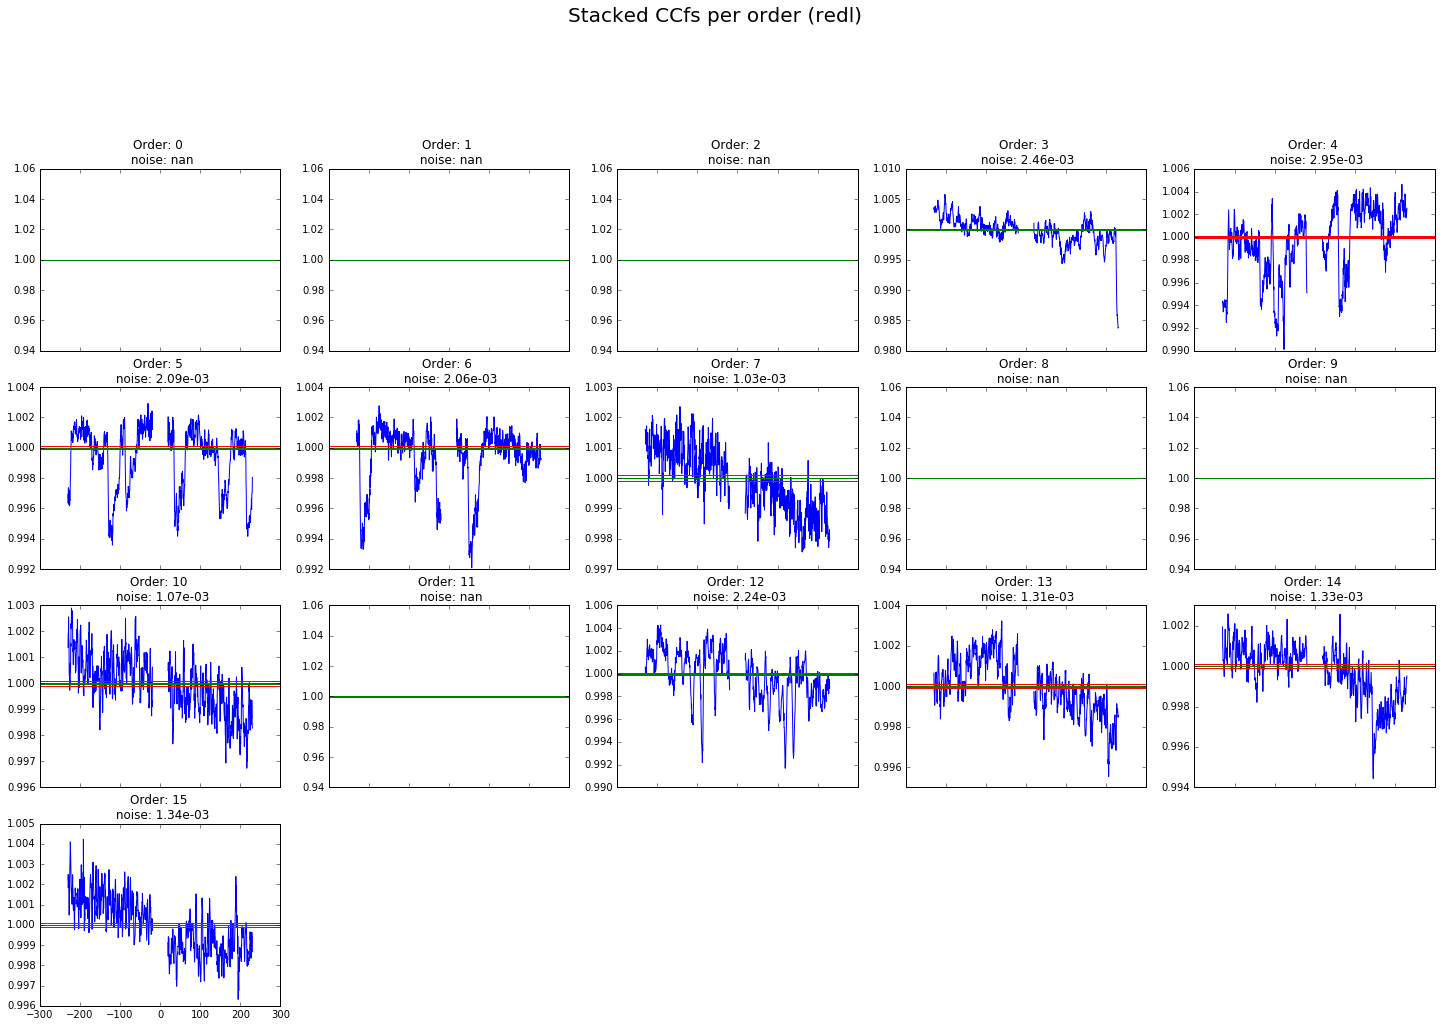

ccfs stacked
building 2D normalised CCFs per order...


In [12]:
# CCF sum

figNormCCfsStacked1D, axesNormCCfsStacked1D = mplt.subplots(int(nOrders / 5)+1, 5, sharex=True,  figsize=(25,15), dpi = 100)

stackedNormCCFs = [np.nansum([ normCCFs[fileName][order]/np.nanmedian(normCCFs[fileName][order]) for filename in sorted(dataFileList)], axis = 0) for order in np.arange(nOrders)]
    
for order in np.arange(nOrders):
    row = int(order/5.)
    column = int((order%5))    
    stackedNormCCFs[order][trimStarIni: trimStarEnd] = None
    noise1D = np.nanstd(stackedNormCCFs[order]/np.nanmedian(stackedNormCCFs[order]))
    axesNormCCfsStacked1D[row, column].plot(waveFile,stackedNormCCFs[order]/np.nanmedian(stackedNormCCFs[order]))
    axesNormCCfsStacked1D[row, column].axhline(1.-1e-4, color='red')
    axesNormCCfsStacked1D[row, column].axhline(1.+1e-4, color='red')
    axesNormCCfsStacked1D[row, column].axhline(1.-1e-5, color='green')
    axesNormCCfsStacked1D[row, column].axhline(1.+1e-5, color='green')
    axesNormCCfsStacked1D[row, column].ticklabel_format(useOffset=False)
    axesNormCCfsStacked1D[row, column].set_title('Order: {:.0f} \n noise: {:.2e}'.format(order, noise1D))

figNormCCfsStacked1D.suptitle('Stacked CCfs per order ({})'.format(side), y=1.05, fontsize = 20)    

for order in np.arange(nOrders, 5*(int(nOrders/5)+1)):
    row = int(order/5.)
    column = int((order%5))
    figNormCCfsStacked1D.delaxes(axesNormCCfsStacked1D[row, column])


mplt.show()
print 'ccfs stacked'
print 'building 2D normalised CCFs per order...'


stacking 2D normalised CCFs orders with noise < 0.0002 ...


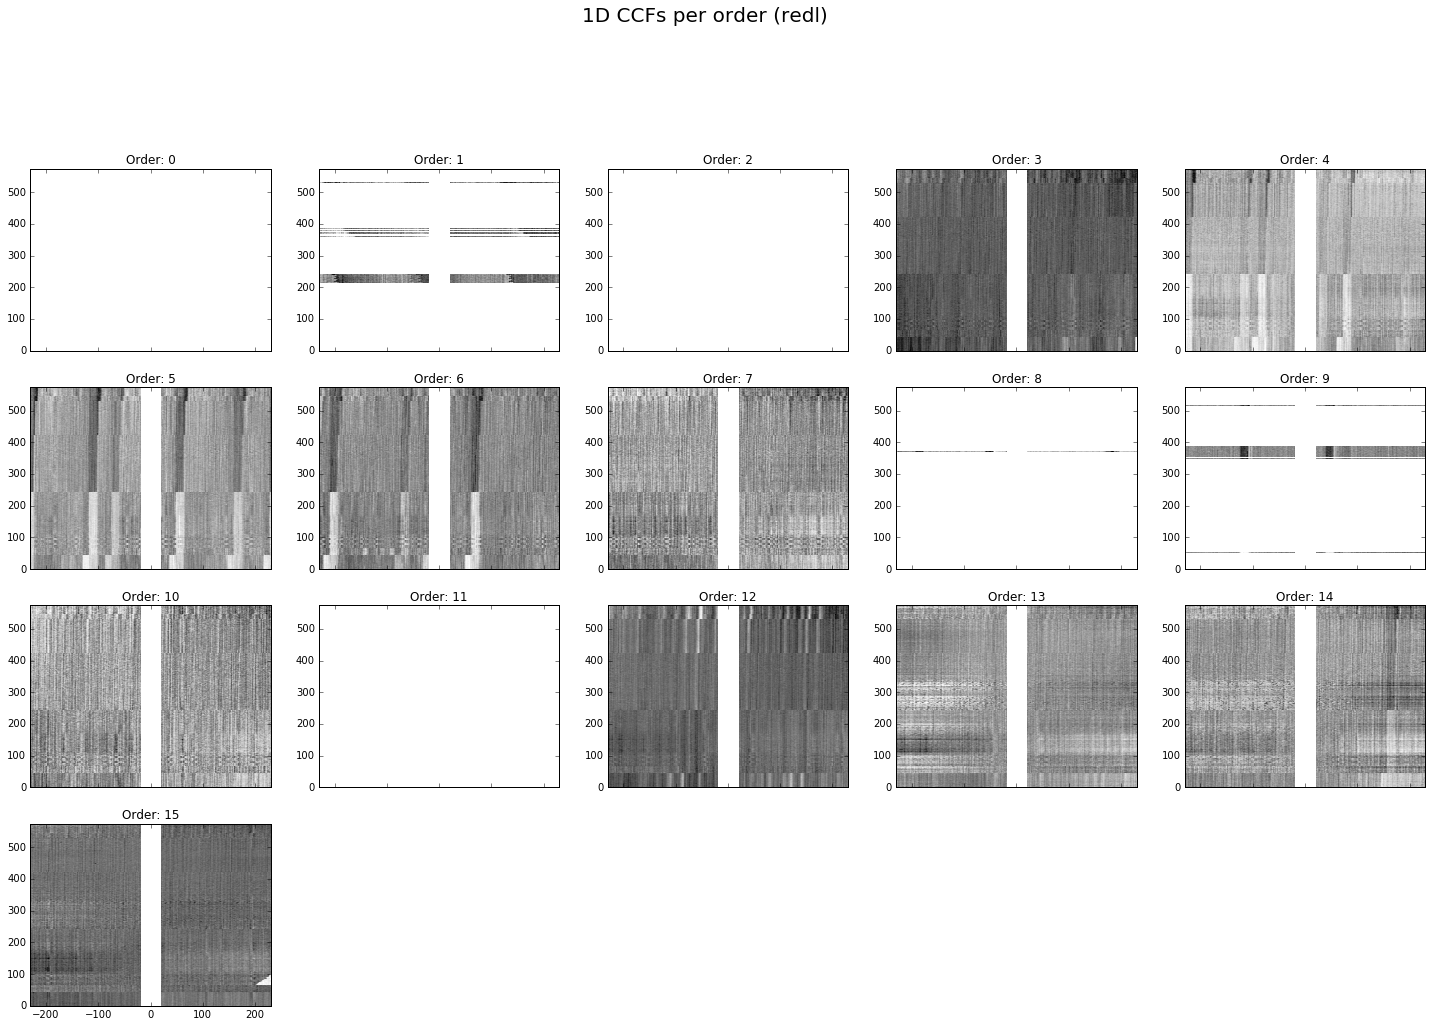

In [13]:
#2D ccfs
figNormCCfsOrders2D, axesNormCCfsOrders2D = mplt.subplots(int(nOrders / 5)+1, 5, sharex=True,  figsize=(25,15), dpi = 100)

# Annotates        
for order in np.arange(nOrders):
    row = int(order/5.)
    column = int((order%5))
    

    axesNormCCfsOrders2D[row, column].imshow([normCCFs[fileName][order]/np.nanmedian(normCCFs[fileName][order]) for fileName in sorted(dataFileList)], aspect='auto', cmap=cm.Greys,interpolation='nearest',\
           extent= [min(waveFile), max(waveFile), 0, len(sorted(dataFileList))])

    axesNormCCfsOrders2D[row, column].set_ylim([0, len(sorted(dataFileList))])
    axesNormCCfsOrders2D[row, column].set_xlim([min(waveFile), max(waveFile)])
    axesNormCCfsOrders2D[row, column].set_title('Order: {:.0f}'.format(order))

figNormCCfsOrders2D.suptitle('1D CCFs per order ({})'.format(side), y=1.05, fontsize = 20) 

for order in np.arange(nOrders, 5*(int(nOrders/5)+1)):
    row = int(order/5.)
    column = int((order%5))
    figNormCCfsOrders2D.delaxes(axesNormCCfsOrders2D[row, column])

print 'stacking 2D normalised CCFs orders with noise < %s ...' %noiseLimitData

(0, 573)

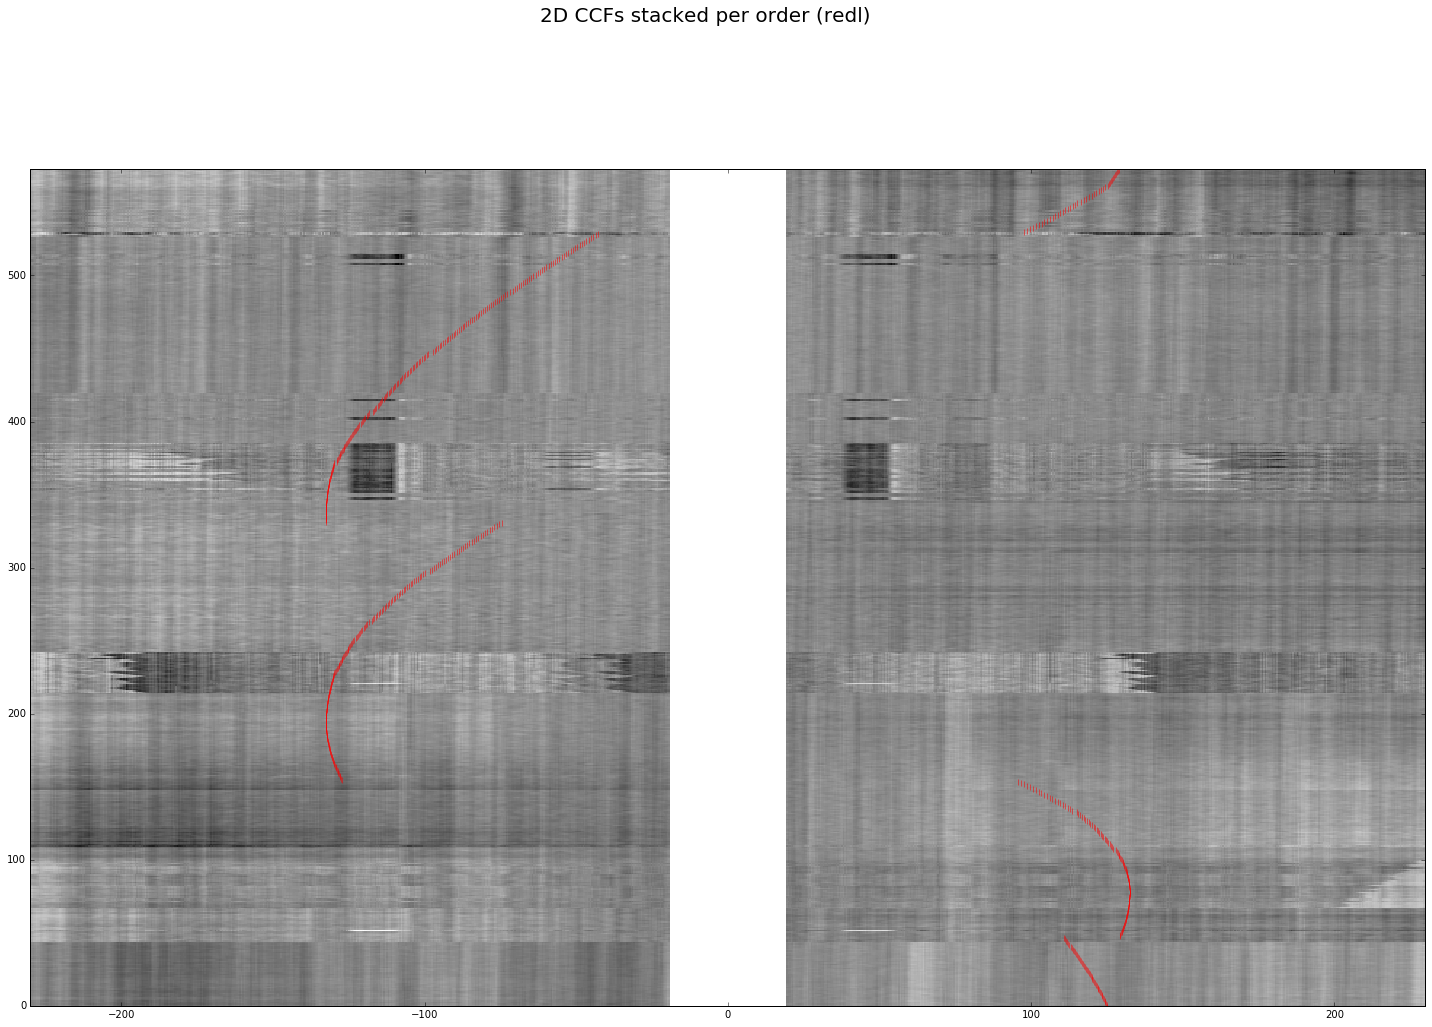

In [14]:
# sum selected 2D CCFs

badOrders = [0]

goodOrders = [order for order in np.arange(nOrders) if (noiseSTD[order] < 1.e-2) and order not in badOrders]

ccfStack2D = []
dataFileListSelected = []

for fileName in sorted(dataFileList):
    ccf = np.array(np.nansum([normCCFs[fileName][order] for order in goodOrders], axis=0))
    ccfNew= ccf.copy()/np.nanmedian(ccf.copy())
    ccfNew[trimStarIni:trimStarEnd] = np.nan
        
    ccfStack2D.append(ccfNew)


    #plots
figCCFsStackedOrders2D, axesCCFsStackedOrders2D = mplt.subplots(1,1, sharex=True,  figsize=(25,15), dpi = 100)
figCCFsStackedOrders2D.suptitle('2D CCFs stacked per order ({})'.format(side), y=1.05, fontsize = 20) 

axesCCFsStackedOrders2D.imshow(ccfStack2D, \
                              aspect='auto', cmap=cm.Greys,interpolation='nearest',\
                              extent= [min(waveFile), max(waveFile), 0, len(dataFileList)]\
                              )

axesCCFsStackedOrders2D.plot([RVs[fileName] for fileName in sorted(dataFileList)], [yy-.5 for yy in np.arange(len(dataFileList))], 'r|')

axesCCFsStackedOrders2D.set_xlim([min(waveFile), max(waveFile)])
axesCCFsStackedOrders2D.set_ylim([0, len(dataFileList)-1])


In [15]:
# sum selected 2D CCFs

badOrders = [0]

goodOrders = [order for order in np.arange(nOrders) if (noiseSTD[order] < 1.e-2) and order not in badOrders]

ccfStack2D = []
dataFileListSelected = []

for fileName in sorted(dataFileList):
    ccf = np.array(np.nansum([normCCFs[fileName][order] for order in goodOrders], axis=0))
    ccfNew= ccf.copy()/np.nanmedian(ccf.copy())

    #m , b = np.polyfit(waveFile[0], ccfNew, 1)
    #fit = np.array([m*x+b for x in waveFile[0]])
    #ccfNew = ccfNew.copy()/fit.copy()
    #print np.shape(ccfNew)

    ccfNew[trimStarIni:trimStarEnd] = np.nan
        
    ccfStack2D.append(ccfNew)


    #plots
figCCFsStackedOrders2D, axesCCFsStackedOrders2D = mplt.subplots(1,1, sharex=True,  figsize=(25,15), dpi = 100)
figCCFsStackedOrders2D.suptitle('2D CCFs stacked per order ({})'.format(side), y=1.05, fontsize = 20) 

axesCCFsStackedOrders2D.imshow(ccfStack2D, \
                              aspect='auto', cmap=cm.Greys,interpolation='nearest',\
                              extent= [min(waveFile), max(waveFile), 0, len(dataFileList)]\
                              )

axesCCFsStackedOrders2D.plot([RVs[fileName] for fileName in sorted(dataFileList)], [yy-.5 for yy in np.arange(len(dataFileList))], 'r|')



for fileName,yy  in zip(sorted(dataFileList),np.arange(len(dataFileList))):
    axesCCFsStackedOrders2D.add_patch(patches.Rectangle( (RVs[fileName]- planetTrimRV, yy), 2*planetTrimRV, 1., color='g', alpha=0.05))
    
    
    #axhspan(waveFile[RVIndexes[fileName][0]], waveFile[RVIndexes[fileName][-1]], color='y', alpha=0.5, lw=0)

axesCCFsStackedOrders2D.set_xlim([min(waveFile), max(waveFile)])
axesCCFsStackedOrders2D.set_ylim([0, len(dataFileList)-1])


(0, 573)

In [16]:
# 2D CCFs selected centered on planet and selected byt RV
step = abs(waveFile[1]-waveFile[0])

figPlanetCCFsStackedOrders2D, axesPlanetCCFsStackedOrders2D = mplt.subplots(2,1, sharex=True,  figsize=(25,15), dpi = 100)
figPlanetCCFsStackedOrders2D.suptitle('planet 2D CCFs stacked per order and centered on planet({})'.format(side), y=1.05, fontsize = 20) 


ccfPlanetCenteredLeft = [(ccf/np.nanmedian(ccf))[index-planetTrimRV/step:index + planetTrimRV/step] \
                    for ccf, index, RV in zip(ccfStack2D, [RVIndexes[fileName] for fileName in sorted(dataFileList)], [RVs[fileName] for fileName in sorted(dataFileList)]) \
                    if (abs(RV) > (planetTrimRV + ccfStarTrimRV)) ]

ccfPlanetCenteredRight = [(ccf/np.nanmedian(ccf))[index-planetTrimRV/step:index + planetTrimRV/step] \
                    for ccf, index, RV in zip(ccfStack2D, [RVIndexes[fileName] for fileName in sorted(dataFileList)], [RVs[fileName] for fileName in sorted(dataFileList)]) \
                    if (abs(RV) > (planetTrimRV + ccfStarTrimRV)) ]


axesPlanetCCFsStackedOrders2D[0].imshow(ccfPlanetCenteredLeft, \
                              aspect='auto', cmap=cm.Greys,interpolation='nearest',\
                              extent= [min(waveFile), max(waveFile), 0, len(dataFileList)]\
                              )

axesPlanetCCFsStackedOrders2D[1].imshow(ccfPlanetCenteredRight, \
                              aspect='auto', cmap=cm.Greys,interpolation='nearest',\
                              extent= [min(waveFile), max(waveFile), 0, len(dataFileList)]\
                              )
mplt.show()

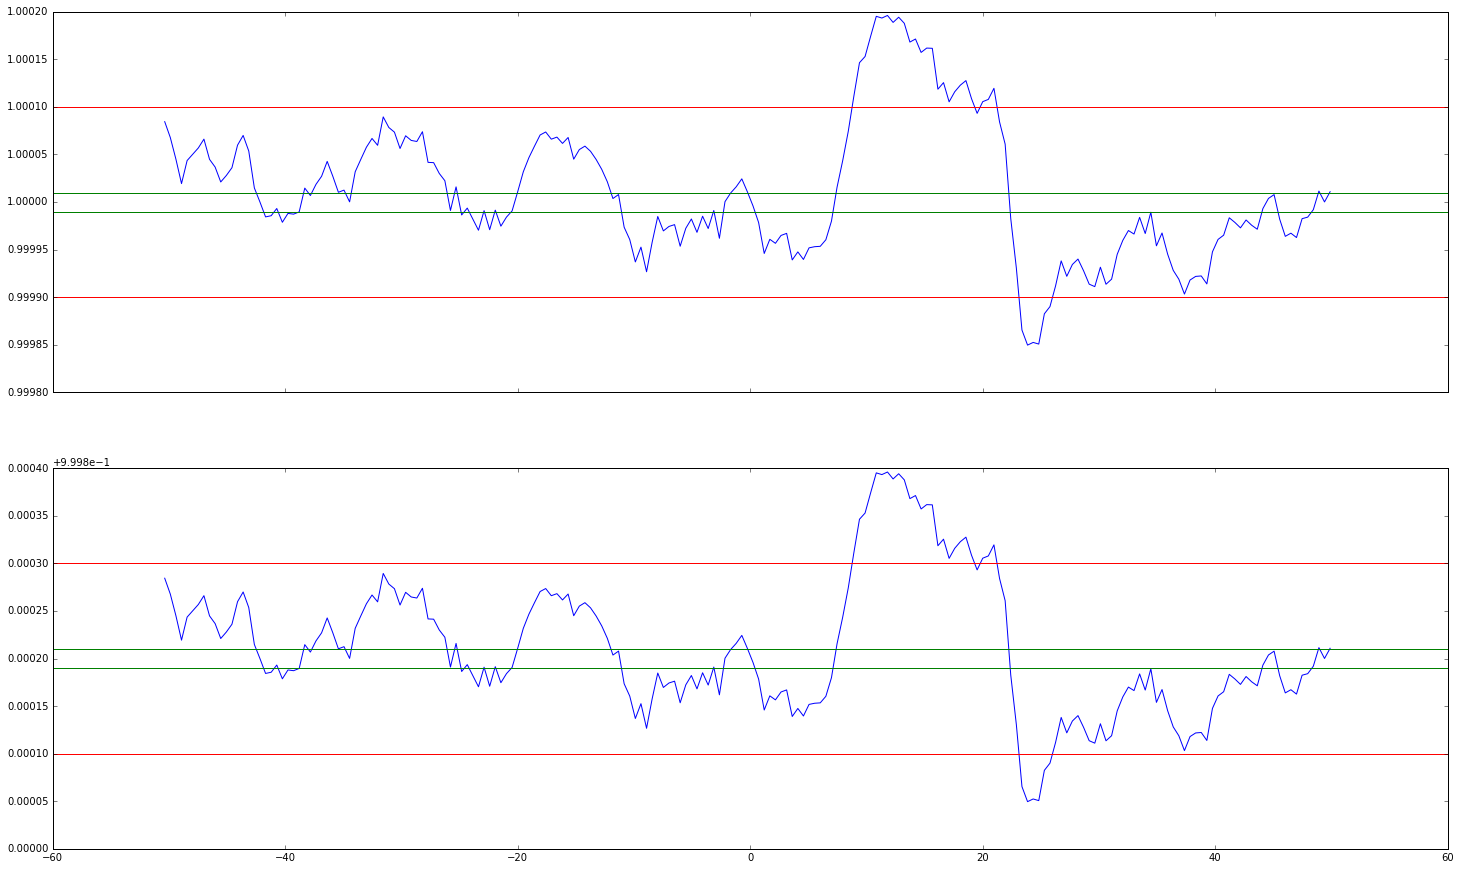

In [17]:
# CCF sum "Planet"



#ccfSum = np.nansum([(ccf/np.nanmedian(ccf))[index-planetTrimRV/step:index + planetTrimRV/step] \
#                    for ccf, index, RV in zip(ccfStack2D, [RVIndexes[fileName] for fileName in sorted(dataFileList)], [RVs[fileName] for fileName in sorted(dataFileList)]) \
#                    if abs(RV) > (planetTrimRV + ccfStarTrimRV)], axis=0)


#ccfSum[len(ccfSum)/2 -50 :len(ccfSum)/2 + 50] = None
ccfSumleft = np.nansum(ccfPlanetCenteredLeft, axis=0)
ccfSumRight = np.nansum(ccfPlanetCenteredRight, axis=0)

ccfSumNormLeft = ccfSumleft/np.nanmedian(ccfSumleft)
ccfSumNormRight = ccfSumRight/np.nanmedian(ccfSumRight)
#display(Math(r'$$1-\sigma \; Noise: {:.2e}$$'.format(np.nanstd(ccfSumNorm))))

# plots
figPlanetCCF, axesPlanetCCF = mplt.subplots(2,1, sharex=True,  figsize=(25,15), dpi = 100)
axesPlanetCCF[0].ticklabel_format(useOffset=False)
axesPlanetCCF[0].plot(np.linspace(-len(ccfSumleft)/2*step,len(ccfSumleft)/2*step, num = len(ccfSumNormLeft) ),ccfSumNormLeft)
axesPlanetCCF[1].plot(np.linspace(-len(ccfSumNormRight)/2*step,len(ccfSumNormRight)/2*step, num = len(ccfSumNormRight) ),ccfSumNormRight)

axesPlanetCCF[0].axhline(1.-1e-4, color='red')
axesPlanetCCF[0].axhline(1.+1e-4, color='red')
axesPlanetCCF[0].axhline(1.-1e-5, color='green')
axesPlanetCCF[0].axhline(1.+1e-5, color='green')

axesPlanetCCF[1].axhline(1.-1e-4, color='red')
axesPlanetCCF[1].axhline(1.+1e-4, color='red')
axesPlanetCCF[1].axhline(1.-1e-5, color='green')
axesPlanetCCF[1].axhline(1.+1e-5, color='green')

mplt.show()